<a href="https://colab.research.google.com/github/Dnyanada-Jalindre-18/Deep-Learning/blob/main/LSTM_tweets_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis : Twitter Reviews classification 

## Importing Libraries

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import zipfile
import re

from keras.layers import Dense, Dropout, LSTM, Embedding, SpatialDropout1D
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

## Importing dataset
Our dataset is sqlite file so we need to import that file first and then making it into readable format

In [16]:
# Extracting files under database.sqlite.zip
with zipfile.ZipFile('/content/drive/MyDrive/database.sqlite.zip') as file:
    file.extractall("")

In [17]:
# Making connection to the database
conn = sqlite3.connect('/content/database.sqlite')
cur = conn.cursor()

In [18]:
# for accessing each row of the dataset
for row in cur.execute('select name from sqlite_master where type="table"'):
    print(row)

('Sentiment',)


Now we've just extracted table name, we need to read the data from that "Sentiment" table. For that we'll be using pd.read_sql_query() method .

In [19]:
# for reading the data from sqlite file 
data = pd.read_sql_query('select * from Sentiment', conn)
conn.close()

In [20]:
# let's check Sentiment table
data.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,name,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,,I_Am_Kenzi,,5,,,RT @NancyLeeGrahn: How did everyone feel about...,,2015-08-07 09:54:46 -0700,629697200650592256,,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,,PeacefulQuest,,26,,,RT @ScottWalker: Didn't catch the full #GOPdeb...,,2015-08-07 09:54:46 -0700,629697199560069120,,
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,,PussssyCroook,,27,,,RT @TJMShow: No mention of Tamir Rice and the ...,,2015-08-07 09:54:46 -0700,629697199312482304,,
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,,MattFromTexas31,,138,,,RT @RobGeorge: That Carly Fiorina is trending ...,,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,,sharonDay5,,156,,,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,,2015-08-07 09:54:45 -0700,629697196967903232,,Arizona


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13871 entries, 0 to 13870
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         13871 non-null  int64  
 1   candidate                  13871 non-null  object 
 2   candidate_confidence       13871 non-null  float64
 3   relevant_yn                13871 non-null  object 
 4   relevant_yn_confidence     13871 non-null  float64
 5   sentiment                  13871 non-null  object 
 6   sentiment_confidence       13871 non-null  float64
 7   subject_matter             13871 non-null  object 
 8   subject_matter_confidence  13871 non-null  float64
 9   candidate_gold             13871 non-null  object 
 10  name                       13871 non-null  object 
 11  relevant_yn_gold           13871 non-null  object 
 12  retweet_count              13871 non-null  int64  
 13  sentiment_gold             13871 non-null  obj

In [22]:
data.corr()

,id,candidate_confidence,relevant_yn_confidence,sentiment_confidence,subject_matter_confidence,retweet_count,tweet_id
id,1.000000,0.081504,0.088986,0.051172,0.079515,-0.040689,-0.898911
candidate_confidence,0.081504,1.000000,0.932458,0.506682,0.749057,0.020614,-0.083695
relevant_yn_confidence,0.088986,0.932458,1.000000,0.518682,0.792923,0.021756,-0.088960
sentiment_confidence,0.051172,0.506682,0.518682,1.000000,0.431655,0.008324,-0.062428
subject_matter_confidence,0.079515,0.749057,0.792923,0.431655,1.000000,0.030302,-0.077708
retweet_count,-0.040689,0.020614,0.021756,0.008324,0.030302,1.000000,-0.016831
tweet_id,-0.898911,-0.083695,-0.088960,-0.062428,-0.077708,-0.016831,1.000000


In [23]:
# for simplicity we are considering only two columns : Sentiment and text
data = data[['sentiment','text']]

In [24]:
data.head()

,sentiment,text
0,Neutral,RT @NancyLeeGrahn: How did everyone feel about...
1,Positive,RT @ScottWalker: Didn't catch the full #GOPdeb...
2,Neutral,RT @TJMShow: No mention of Tamir Rice and the ...
3,Positive,RT @RobGeorge: That Carly Fiorina is trending ...
4,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...


In [26]:
# For more simplicity let's remove Neutral tweets
data = data[data.sentiment!='Neutral']

In [27]:
# Now we have sentiment values as positive and negative.
data.head()

,sentiment,text
1,Positive,RT @ScottWalker: Didn't catch the full #GOPdeb...
3,Positive,RT @RobGeorge: That Carly Fiorina is trending ...
4,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...
5,Positive,"RT @GregAbbott_TX: @TedCruz: ""On my first day ..."
6,Negative,RT @warriorwoman91: I liked her and was happy ...


In [59]:
# Checking for any missing data
data.isnull().sum()

sentiment    0
text         0
dtype: int64

In [28]:
# unique values of sentiment columns. Two values found : Positive, Negative
data['sentiment'].unique()

array(['Positive', 'Negative'], dtype=object)

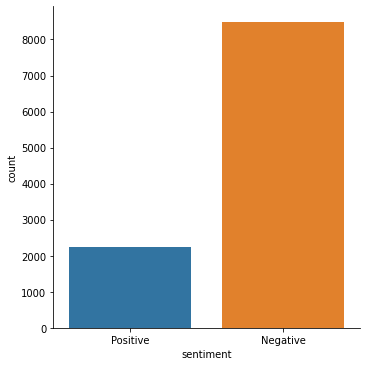

In [32]:
sns.catplot(x = 'sentiment', kind = 'count', data = data)

Now converting the data into lower case and removing all unnecessary symbols.

In [36]:
data['text'] = data['text'].apply(lambda x : x.lower())
data['text'].iloc[0]

"rt @scottwalker: didn't catch the full #gopdebate last night. here are some of scott's best lines in 90 seconds. #walker16 http://t.co/zsff…"

In [53]:
# lambda function for removing http... and converting string into lower case
data['text'] = data['text'].apply(lambda x : re.sub('[^a-zA-Z0-9\s]http[\S]+','',x))

# lambda function for removing 'rt' (present at the beginning of every tweet)
data['text'] = data['text'].apply(lambda y : re.sub('rt','',y))

data['text'].iloc[0]

' scottwalker didnt catch the full gopdebate last night here are some of scotts best lines in 90 seconds walker16 '

In [54]:
data.head()

,sentiment,text
1,Positive,scottwalker didnt catch the full gopdebate la...
3,Positive,robgeorge that carly fiorina is trending hou...
4,Positive,danscavino gopdebate w realdonaldtrump delive...
5,Positive,gregabbotttx tedcruz on my first day i will r...
6,Negative,warriorwoman91 i liked her and was happy when...


In [61]:
max_features = 3000
tokenizer = Tokenizer(num_words=max_features, split=" ")
# num_words : the maximum number of words to keep, based on word frequency
# split : str. Separator for word splitting.

tokenizer.fit_on_texts(data['text'].values)
# fit_on_texts() : Updates internal vocabulary based on a list of texts

seq = tokenizer.texts_to_sequences(data['text'].values)
# texts_to_sequences() : Transforms each text in texts to a sequence of integers

In [62]:
data['text'].values

array([' scottwalker didnt catch the full gopdebate last night here are some of scotts best lines in 90 seconds walker16 ',
       ' robgeorge that carly fiorina is trending  hours after her debate  above any of the men in justcompleted gopdebate says shes on ',
       ' danscavino gopdebate w realdonaldtrump delivered the highest ratings in the history of presidential debates trump2016 ',
       ...,
       ' lrihendry tedcruz as president i will always tell the truth and do what i said i would do  gopdebates',
       ' jrehling gopdebate donald trump says that he doesnt have time for political correctness how does calling women fat pigs save him ',
       ' lrihendry tedcruz headed into the presidential debates go ted \n\ngopdebates '],
      dtype=object)

In [68]:
print(seq[1])
print(len(seq[1]))

[16, 281, 249, 5, 799, 102, 169, 26, 2741, 133, 6, 1, 170, 12, 2, 231, 707, 17]
18


In [70]:
print(seq[2])
print(len(seq[2]))

[1230, 2, 307, 23, 1902, 1, 1593, 213, 12, 1, 687, 6, 183, 204, 366]
15


In [71]:
print(seq[4])
print(len(seq[4]))

[2742, 9, 1122, 169, 8, 21, 1291, 63, 9, 603, 185, 21, 186, 4, 34, 1, 554, 19, 800, 2, 44]
21


we can clearly see that the length of sequences are different so we are using padding to make them to the similar length

In [72]:
seq = pad_sequences(seq)

In [73]:
print(seq[1])
print(len(seq[1]))

[   0    0    0    0    0    0    0    0    0    0    0   16  281  249
    5  799  102  169   26 2741  133    6    1  170   12    2  231  707
   17]
29


In [74]:
print(seq[4])
print(len(seq[4]))

[   0    0    0    0    0    0    0    0 2742    9 1122  169    8   21
 1291   63    9  603  185   21  186    4   34    1  554   19  800    2
   44]
29


In [75]:
seq.shape

(10729, 29)

## Locating feature and label

In [77]:
x = seq
y = pd.get_dummies(data['sentiment'],drop_first=True).values

## Splitting the data into train and test set

In [80]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [83]:
# let's take a look at train and test set
print("x_train : ", x_train.shape, "y_train : ", y_train.shape)
print("x_test  : ", x_test.shape, " y_test : ", y_test.shape)

x_train :  (8583, 29) y_train :  (8583, 1)
x_test  :  (2146, 29)  y_test :  (2146, 1)


## Creating our LSTM network

In [89]:
model = Sequential()
model.add(Embedding(max_features, 128, input_length=seq.shape[1])) 
model.add(SpatialDropout1D(0.4))
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(1, activation='sigmoid'))

In [90]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 29, 128)           384000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 29, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 515,713
Trainable params: 515,713
Non-trainable params: 0
_________________________________________________________________


In [91]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [92]:
history = model.fit(x_train,y_train,batch_size=32,epochs=10,validation_data=(x_test,y_test),verbose=1)

Epoch 1/10
269/269 [==============================] - 31s 107ms/step - loss: 0.5073 - accuracy: 0.7942 - val_loss: 0.3576 - val_accuracy: 0.8462
Epoch 2/10
269/269 [==============================] - 28s 105ms/step - loss: 0.3247 - accuracy: 0.8588 - val_loss: 0.3475 - val_accuracy: 0.8551
Epoch 3/10
269/269 [==============================] - 28s 105ms/step - loss: 0.2702 - accuracy: 0.8842 - val_loss: 0.3403 - val_accuracy: 0.8597
Epoch 4/10
269/269 [==============================] - 28s 104ms/step - loss: 0.2356 - accuracy: 0.9041 - val_loss: 0.3482 - val_accuracy: 0.8509
Epoch 5/10
269/269 [==============================] - 29s 106ms/step - loss: 0.2047 - accuracy: 0.9170 - val_loss: 0.3959 - val_accuracy: 0.8406
Epoch 6/10
269/269 [==============================] - 28s 104ms/step - loss: 0.1813 - accuracy: 0.9289 - val_loss: 0.4074 - val_accuracy: 0.8509
Epoch 7/10
269/269 [==============================] - 28s 105ms/step - loss: 0.1661 - accuracy: 0.9357 - val_loss: 0.4168 - val_ac

In [93]:
model.evaluate(x_test, y_test)

68/68 [==============================] - 0s 7ms/step - loss: 0.5210 - accuracy: 0.8444


[0.5209982395172119, 0.8443616032600403]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


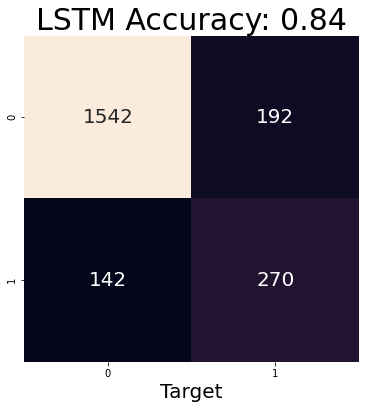

In [97]:
y_pred = model.predict_classes(x_test)
plt.subplots(figsize=(6,6))

sns.heatmap(confusion_matrix(y_pred,y_test),annot=True,fmt="1.0f",cbar=False,annot_kws={"size": 20})

plt.title(f"LSTM Accuracy: {round(accuracy_score(y_pred,y_test),2)}",fontsize=30)
plt.xlabel("Target",fontsize=20)
plt.show()

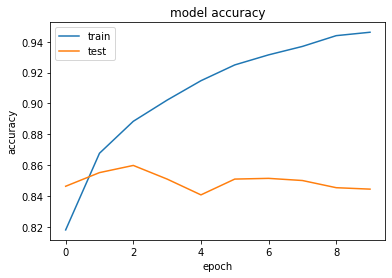

In [98]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

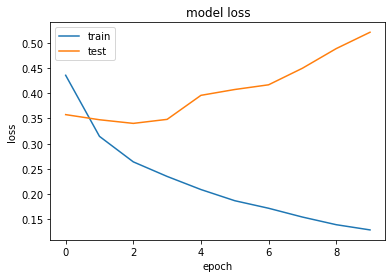

In [99]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()